# 환경 세팅

In [1]:
import os
import random
import torch
import utils
import modeling_finetune
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd    
from custom_dataset import CustomVQADataset
from timm.models import create_model
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
from transformers import XLMRobertaTokenizer


current_path = os.getcwd()
custom_dataset_path = os.path.join(current_path, 'custom_dataset')
jsonl_path = os.path.join(custom_dataset_path, '[google]custom.vqa.test.jsonl')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

print(f'CUDA Available: {torch.cuda.is_available()}')

CUDA Available: True


# 데이터세트 준비

In [2]:
test_dataset = CustomVQADataset(jsonl_path=jsonl_path, img_size=768)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True,)

# 모델 불러오기

In [3]:
model_config = 'beit3_large_patch16_768_vqav2'
model = create_model(
    model_config,
    pretrained=False,
    drop_path_rate=0.1,
    vocab_size=64010
)

utils.load_model_and_may_interpolate(
    ckpt_path=os.path.join(current_path, 'model', 'beit3_large_indomain_patch16_768_vgqaaug_vqa.zip'),
    model=model,
    model_key='model|module',
    model_prefix=''
)

model.eval()
model.to(device)

Load ckpt from d:\Codes\python_projects_windows\VQA\BEiT-3\unilm\beit3\Custom_BEiT-3\model\beit3_large_indomain_patch16_768_vgqaaug_vqa.zip
Load state_dict by model_key = model


BEiT3ForVisualQuestionAnswering(
  (beit3): BEiT3(
    (text_embed): TextEmbedding(64010, 1024)
    (vision_embed): VisionEmbedding(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): Encoder(
      (dropout_module): Dropout(p=0.0, inplace=False)
      (embed_positions): MutliwayEmbedding(
        (A): PositionalEmbedding(2307, 1024)
        (B): PositionalEmbedding(1024, 1024)
      )
      (layers): ModuleList(
        (0): EncoderLayer(
          (self_attn): MultiheadAttention(
            (k_proj): MultiwayNetwork(
              (A): Linear(in_features=1024, out_features=1024, bias=True)
              (B): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (v_proj): MultiwayNetwork(
              (A): Linear(in_features=1024, out_features=1024, bias=True)
              (B): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (q_proj): MultiwayNetwork(
              (A): Linear(in_feat

# 추론

In [4]:
save_jsonl_path = os.path.join(current_path, 'output', 'submit_[google].jsonl')

tokenizer_path = os.path.join(current_path,'model','beit3.spm')
default_tokenizer = XLMRobertaTokenizer(tokenizer_path)

preds = []
with torch.no_grad():
    try:
        progress = 0
        counter = 0
        for data in tqdm(test_loader):
            # if counter == 4:
            #     raise KeyError
            if counter >= progress:
                images = data['image'].to(device)
                question = data['question'].to(device)
                padding_mask = data['padding_mask'].to(device)

                outputs = model(images, question, padding_mask)

                _, pred = outputs.max(-1)
                for index, x in enumerate(pred):
                    preds.append({"question":default_tokenizer.decode(data['question'][index], skip_special_tokens= True), "answer":test_dataset.label2ans[x]})
            
            counter += 1
    except:
        print(f'Progress: {counter}')
        for pred in preds:
            # print(pred)
            with open(save_jsonl_path, "a", encoding='utf-8') as f:
                    f.write(json.dumps(pred, ensure_ascii=False) + "\n")

  0%|          | 0/108463 [00:00<?, ?it/s]

Progress: 6


결과 시각화

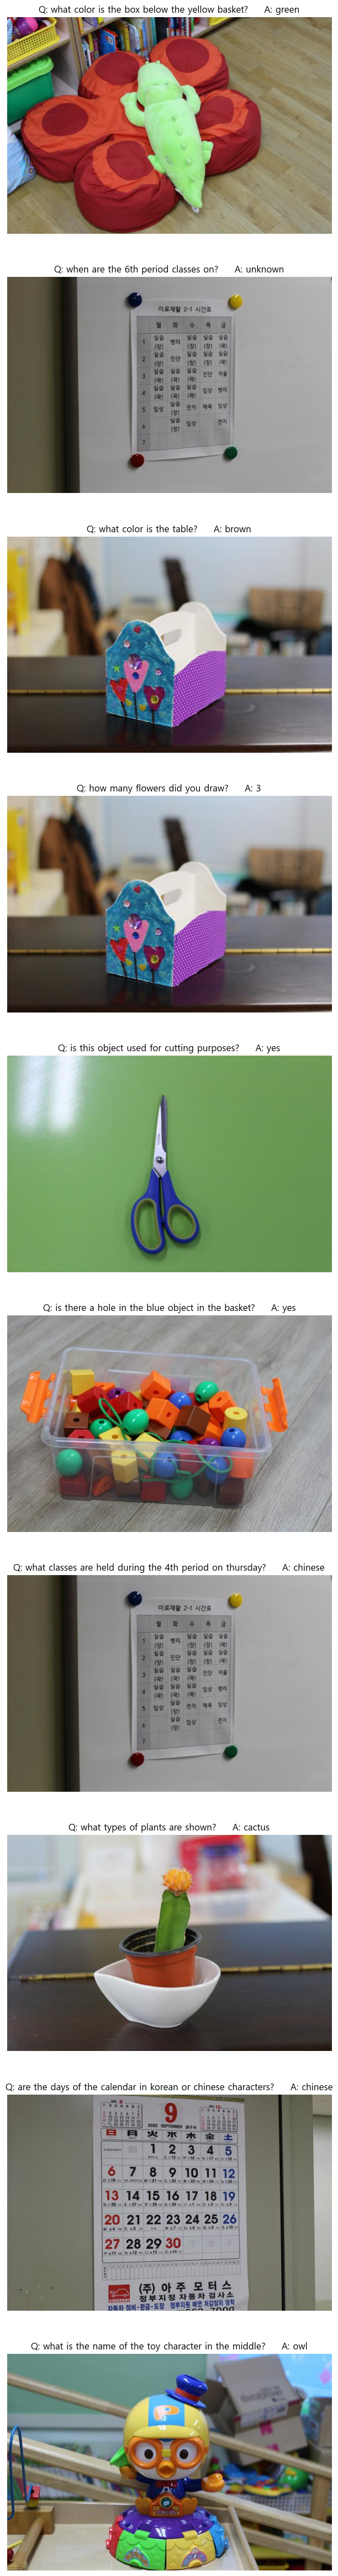

In [7]:
test_df = pd.read_json(path_or_buf=jsonl_path, lines=True, encoding='utf-8')
answers_df = pd.read_json(path_or_buf=save_jsonl_path, lines=True, encoding='utf-8')

fig, axes = plt.subplots(10, 1, figsize=(80, 60))

from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가
font_path = "C:/Windows/Fonts/malgun.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

length = len(answers_df)
for idx, value in enumerate(random.sample(range(length), 10)):
    img_array = np.fromfile(os.path.join(custom_dataset_path, test_df.iloc[value]["image_path"]), np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[idx].imshow(img)
    axes[idx].set_title(f'Q: {answers_df.iloc[value]["question"]}     A: {answers_df.iloc[value]["answer"]}')
    axes[idx].axis('off')

